In [1]:
 # mount your drive with files
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# install monai

!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

     |████████████████████████████████| 1.0 MB 8.3 MB/s 


In [3]:
# import libraries 

import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import nibabel as nib 

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    RandBiasFieldd,
    RandAdjustContrastd,
    RandGaussianNoised,
    RandAffined,
    ToTensord,
    
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

import torch
# print_config()


# switch off warning messages
import warnings
warnings.filterwarnings("ignore")


In [4]:
# set path to the folder with files

directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory

root_dir='/content/drive/My Drive/Colab Notebooks/MSc Fetal Brain Project/'
data_dir = '/content/drive/My Drive/Colab Notebooks/MSc Fetal Brain Project/'
print(root_dir)
os.chdir(root_dir)


/content/drive/My Drive/Colab Notebooks/MSc Fetal Brain Project/


In [5]:
# define data loaders and augmentation for training and validation

degree_min = -1.05
degree_max = 1.05


train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=500,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        RandAdjustContrastd(
            keys=["image"],
            prob=0.80,
        ),
        RandBiasFieldd(
            keys=["image"],
            prob=0.50,
        ),     
        RandAffined(
            keys=["image", "label"],
            rotate_range=[(degree_min,degree_max),(degree_min,degree_max),(degree_min,degree_max)],
            mode=("bilinear", "nearest"),
            padding_mode=("zeros"),
            prob=0.70,
        ),
        RandGaussianNoised(
        keys=["image"],
        prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=500, b_min=0.0, b_max=1.0, clip=True
        ),

        ToTensord(keys=["image", "label"]),
    ]
)

test_transforms = Compose(

    [
     LoadImaged(keys=["image"]),
     AddChanneld(keys=["image"]),
     ScaleIntensityRanged(
         keys=["image"], a_min=0, a_max=500, b_min=0.0, b_max=1.0, clip=True
     )
     
    ]

)

In [6]:
# load the files based on the lists in .json (it should be located in your data folder)
data_dir = '/content/drive/My Drive/Colab Notebooks/MSc Fetal Brain Project/'

split_JSON = "new-fetal-files-for-manisha-072022/dhcp-neonatal-dataset-tissue-final2.json"
datasets = data_dir + split_JSON

datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
test_files = load_decathlon_datalist(datasets, True, "test")

train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=100,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True
)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

test_ds = CacheDataset(
    data=test_files, transform=test_transforms, cache_num=6, cache_rate=1.0, num_workers=4

)
test_loader = DataLoader(
    test_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

Loading dataset: 100%|██████████| 6/6 [00:01<00:00,  3.92it/s]


In [ ]:
from monai.utils import first
from monai.visualize import matshow3d

# train_transforms = Compose(
#     [
#         LoadImaged(keys=["image", "label"]),
#         AddChanneld(keys=["image", "label"]),
#         #ScaleIntensityRanged(keys=["image"],a_min=0,a_max=500,b_min=0.0,b_max=1.0,clip=True),
#         #RandAdjustContrastd(keys=["image"],prob=0.80),
#         #RandBiasFieldd(keys=["image"],prob=0.80),
#         #RandAffined(keys=["image", "label"],rotate_range=[(degree_min,degree_max),(degree_min,degree_max),(degree_min,degree_max)],mode=("bilinear", "nearest"),padding_mode=("zeros"),prob=0.70),
#         #RandGaussianNoised(keys=["image"],prob=0.50),

#         ToTensord(keys=["image", "label"]),
#     ]
# )

for data in train_loader:
  print(f"image shape: {data['image'].shape}, label shape: {data['label'].shape}")

# data = first(train_loader)
# print(f"image shape: {data['image'].shape}, label shape: {data['label'].shape}")

  matshow3d(
      volume=data['image'],
      fig=None, title="input image",
      figsize=(10, 10),
      every_n=10,
      frame_dim=-1,
      show=True,
      cmap="gray",
  )



Output hidden; open in https://colab.research.google.com to view.

In [7]:
# Check data is correct
print(len(datalist))
print(len(val_files))
print(len(test_files))

res_datalist = list(set(val for dic in datalist for val in dic.values()))
res_val_files = list(set(val2 for dic2 in val_files for val2 in dic2.values()))
res_test_files = list(set(val3 for dic3 in test_files for val3 in dic3.values()))

print(len(res_datalist))
print(len(res_val_files))
print(len(res_test_files))

121
20
30
242
40
30


image name =  sub-CC00991XX19_ses-35230_t2.nii.gz
image shape: torch.Size([1, 160, 160, 160]), label shape: torch.Size([1, 160, 160, 160])


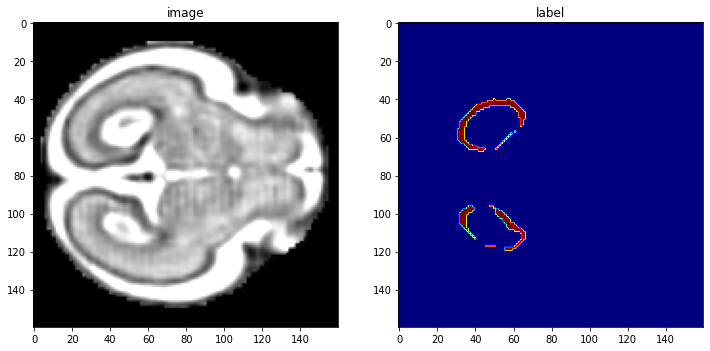

In [8]:
# try visualising one of the validation datasets

s=80  # slice number
case_num = 1
img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
print('image name = ',img_name)
case_in=val_ds[case_num]
img = case_in["image"]
label = case_in["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, s], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, s], cmap="jet")
plt.show()


In [8]:
# set dimensions of the input images (160x160x160) and number of classes (number of labels + background)
img_dim=160
class_num=2


In [9]:
# define the network using MONAI (see examples in https://github.com/Project-MONAI/tutorials/tree/master/3d_segmentation)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=class_num, 
    img_size=(img_dim, img_dim, img_dim),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

# define the loss and optimiser

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)


In [11]:
# define validation and training functions

def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (img_dim, img_dim, img_dim), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(root_dir, "best_metric_model_fetal4.pth") # Filename
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best




In [10]:
# preload the pretrained model (if it exists)

model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_fetal4.pth")))
model.eval()

UNETR(
  (vit): ViT(
    (patch_embedding): PatchEmbeddingBlock(
      (patch_embeddings): Sequential(
        (0): Rearrange('b c (h p1) (w p2) (d p3) -> b (h w d) (p1 p2 p3 c)', p1=16, p2=16, p3=16)
        (1): Linear(in_features=4096, out_features=768, bias=True)
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (blocks): ModuleList(
      (0): TransformerBlock(
        (mlp): MLPBlock(
          (linear1): Linear(in_features=768, out_features=3072, bias=True)
          (linear2): Linear(in_features=3072, out_features=768, bias=True)
          (fn): GELU(approximate=none)
          (drop1): Dropout(p=0.0, inplace=False)
          (drop2): Dropout(p=0.0, inplace=False)
        )
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): SABlock(
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (input_rearrange): Rearrange('b h (qkv l 

In [11]:
# define training parameters
max_iterations = 20000 # 20000
eval_num = 200
post_label = AsDiscrete(to_onehot=True, num_classes=class_num)
post_pred = AsDiscrete(argmax=True, to_onehot=True, num_classes=class_num)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

In [13]:
# run training

while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_fetal4.pth")))


Training (200 / 20000 Steps) (loss=0.81634):  66%|██████▌   | 80/121 [02:04<03:15,  4.76s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4988155007362366 Current Avg. Dice: 0.4988155007362366


Training (400 / 20000 Steps) (loss=0.73519):  31%|███▏      | 38/121 [01:07<05:20,  3.86s/it]

Model Was Saved ! Current Best Avg. Dice: 0.49881551861763 Current Avg. Dice: 0.49881551861763


Training (600 / 20000 Steps) (loss=0.67176):  97%|█████████▋| 117/121 [02:46<00:13,  3.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.49881551861763 Current Avg. Dice: 0.49881551861763


Training (800 / 20000 Steps) (loss=0.62422):  62%|██████▏   | 75/121 [01:52<02:51,  3.73s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4992274433374405 Current Avg. Dice: 0.4992274433374405


Training (1000 / 20000 Steps) (loss=0.59621):  27%|██▋       | 33/121 [00:58<05:36,  3.82s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7188032984733581 Current Avg. Dice: 0.7188032984733581


Training (1200 / 20000 Steps) (loss=0.57984):  93%|█████████▎| 112/121 [02:41<00:34,  3.81s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7389067649841309 Current Avg. Dice: 0.7389067649841309


Training (1400 / 20000 Steps) (loss=0.53348):  58%|█████▊    | 70/121 [01:45<03:13,  3.79s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7695554971694947 Current Avg. Dice: 0.7695554971694947


Training (1600 / 20000 Steps) (loss=0.51272):  23%|██▎       | 28/121 [00:53<05:15,  3.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7695554971694947 Current Avg. Dice: 0.7571833789348602


Training (1800 / 20000 Steps) (loss=0.52212):  88%|████████▊ | 107/121 [02:34<00:46,  3.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7695554971694947 Current Avg. Dice: 0.7541932493448258


Training (2000 / 20000 Steps) (loss=0.50314):  54%|█████▎    | 65/121 [01:39<03:08,  3.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7695554971694947 Current Avg. Dice: 0.742357861995697


Training (2200 / 20000 Steps) (loss=0.44870):  19%|█▉        | 23/121 [00:43<05:35,  3.43s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7695554971694947 Current Avg. Dice: 0.75964375436306


Training (2400 / 20000 Steps) (loss=0.42630):  84%|████████▍ | 102/121 [02:30<01:13,  3.86s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8101405531167984 Current Avg. Dice: 0.8101405531167984


Training (2600 / 20000 Steps) (loss=0.37774):  50%|████▉     | 60/121 [01:32<03:27,  3.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8101405531167984 Current Avg. Dice: 0.7817316740751267


Training (2800 / 20000 Steps) (loss=0.39137):  15%|█▍        | 18/121 [00:39<06:28,  3.77s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8210689157247544 Current Avg. Dice: 0.8210689157247544


Training (3000 / 20000 Steps) (loss=0.35169):  80%|████████  | 97/121 [02:23<01:39,  4.14s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8324437856674194 Current Avg. Dice: 0.8324437856674194


Training (3200 / 20000 Steps) (loss=0.33818):  45%|████▌     | 55/121 [01:25<03:42,  3.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8324437856674194 Current Avg. Dice: 0.7947930961847305


Training (3400 / 20000 Steps) (loss=0.30473):  11%|█         | 13/121 [00:33<06:59,  3.89s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8398918628692627 Current Avg. Dice: 0.8398918628692627


Training (3600 / 20000 Steps) (loss=0.28100):  76%|███████▌  | 92/121 [02:16<01:49,  3.79s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8428823590278626 Current Avg. Dice: 0.8428823590278626


Training (3800 / 20000 Steps) (loss=0.21157):  41%|████▏     | 50/121 [01:20<04:30,  3.81s/it]

Model Was Saved ! Current Best Avg. Dice: 0.84744433760643 Current Avg. Dice: 0.84744433760643


Training (4000 / 20000 Steps) (loss=0.26715):   7%|▋         | 8/121 [00:24<07:21,  3.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.84744433760643 Current Avg. Dice: 0.8438167154788971


Training (4200 / 20000 Steps) (loss=0.23537):  72%|███████▏  | 87/121 [02:06<01:55,  3.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.84744433760643 Current Avg. Dice: 0.8410238742828369


Training (4400 / 20000 Steps) (loss=0.22775):  37%|███▋      | 45/121 [01:16<04:22,  3.45s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.84744433760643 Current Avg. Dice: 0.810670867562294


Training (4600 / 20000 Steps) (loss=0.24016):   2%|▏         | 3/121 [00:20<14:03,  7.15s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8528437972068786 Current Avg. Dice: 0.8528437972068786


Training (4800 / 20000 Steps) (loss=0.22313):  68%|██████▊   | 82/121 [02:04<02:30,  3.87s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8602770507335663 Current Avg. Dice: 0.8602770507335663


Training (5000 / 20000 Steps) (loss=0.19712):  33%|███▎      | 40/121 [01:08<05:06,  3.79s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8610128670930862 Current Avg. Dice: 0.8610128670930862


Training (5200 / 20000 Steps) (loss=0.20083):  98%|█████████▊| 119/121 [02:48<00:06,  3.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8610128670930862 Current Avg. Dice: 0.856696954369545


Training (5400 / 20000 Steps) (loss=0.19214):  64%|██████▎   | 77/121 [01:53<02:27,  3.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8610128670930862 Current Avg. Dice: 0.8595874339342118


Training (5600 / 20000 Steps) (loss=0.21776):  29%|██▉       | 35/121 [01:01<05:29,  3.83s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8677013665437698 Current Avg. Dice: 0.8677013665437698


Training (5800 / 20000 Steps) (loss=0.20783):  94%|█████████▍| 114/121 [02:44<00:26,  3.78s/it]

Model Was Saved ! Current Best Avg. Dice: 0.87069371342659 Current Avg. Dice: 0.87069371342659


Training (6000 / 20000 Steps) (loss=0.16551):  60%|█████▉    | 72/121 [01:49<02:47,  3.42s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.87069371342659 Current Avg. Dice: 0.8706901937723159


Training (6200 / 20000 Steps) (loss=0.22566):  25%|██▍       | 30/121 [00:52<05:08,  3.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.87069371342659 Current Avg. Dice: 0.8655789196491241


Training (6400 / 20000 Steps) (loss=0.12666):  90%|█████████ | 109/121 [02:37<00:46,  3.90s/it]

Model Was Saved ! Current Best Avg. Dice: 0.877924108505249 Current Avg. Dice: 0.877924108505249


Training (6600 / 20000 Steps) (loss=0.24859):  55%|█████▌    | 67/121 [01:41<03:03,  3.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.877924108505249 Current Avg. Dice: 0.8745480418205261


Training (6800 / 20000 Steps) (loss=0.15151):  21%|██        | 25/121 [00:49<05:46,  3.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.877924108505249 Current Avg. Dice: 0.8698002725839615


Training (7000 / 20000 Steps) (loss=0.17313):  86%|████████▌ | 104/121 [02:32<01:06,  3.92s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8801048338413239 Current Avg. Dice: 0.8801048338413239


Training (7200 / 20000 Steps) (loss=0.16871):  51%|█████     | 62/121 [01:36<03:54,  3.97s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8830499619245529 Current Avg. Dice: 0.8830499619245529


Training (7400 / 20000 Steps) (loss=0.16479):  17%|█▋        | 20/121 [00:43<06:24,  3.80s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8833077013492584 Current Avg. Dice: 0.8833077013492584


Training (7600 / 20000 Steps) (loss=0.15339):  82%|████████▏ | 99/121 [02:23<01:14,  3.41s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8833077013492584 Current Avg. Dice: 0.8696639657020568


Training (7800 / 20000 Steps) (loss=0.13573):  47%|████▋     | 57/121 [01:27<04:08,  3.88s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8861081182956696 Current Avg. Dice: 0.8861081182956696


Training (8000 / 20000 Steps) (loss=0.18529):  12%|█▏        | 15/121 [00:35<06:00,  3.41s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8861081182956696 Current Avg. Dice: 0.8767801910638809


Training (8200 / 20000 Steps) (loss=0.18992):  78%|███████▊  | 94/121 [02:16<01:33,  3.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8861081182956696 Current Avg. Dice: 0.88349609375


Training (8400 / 20000 Steps) (loss=0.17629):  43%|████▎     | 52/121 [01:23<04:27,  3.87s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8896366328001022 Current Avg. Dice: 0.8896366328001022


Training (8600 / 20000 Steps) (loss=0.14572):   8%|▊         | 10/121 [00:29<07:17,  3.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8896366328001022 Current Avg. Dice: 0.8890766054391861


Training (8800 / 20000 Steps) (loss=0.16464):  74%|███████▎  | 89/121 [02:09<01:48,  3.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8896366328001022 Current Avg. Dice: 0.8874206095933914


Training (9000 / 20000 Steps) (loss=0.19149):  39%|███▉      | 47/121 [01:16<04:50,  3.93s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8920175820589066 Current Avg. Dice: 0.8920175820589066


Training (9200 / 20000 Steps) (loss=0.11923):   4%|▍         | 5/121 [00:21<09:49,  5.08s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8920175820589066 Current Avg. Dice: 0.8876835376024246


Training (9400 / 20000 Steps) (loss=0.12543):  69%|██████▉   | 84/121 [02:02<02:06,  3.41s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8920175820589066 Current Avg. Dice: 0.8841841816902161


Training (9600 / 20000 Steps) (loss=0.12479):  35%|███▍      | 42/121 [01:07<04:27,  3.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8920175820589066 Current Avg. Dice: 0.8866380840539932


Training (9800 / 20000 Steps) (loss=0.08840): 100%|██████████| 121/121 [02:53<00:00,  3.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8920175820589066 Current Avg. Dice: 0.8560124337673187


Training (10000 / 20000 Steps) (loss=0.09670):  65%|██████▌   | 79/121 [01:58<02:44,  3.92s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8954374849796295 Current Avg. Dice: 0.8954374849796295


Training (10200 / 20000 Steps) (loss=0.16552):  31%|███       | 37/121 [01:04<04:51,  3.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8954374849796295 Current Avg. Dice: 0.8812100648880005


Training (10400 / 20000 Steps) (loss=0.16996):  96%|█████████▌| 116/121 [02:47<00:20,  4.20s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8959107905626297 Current Avg. Dice: 0.8959107905626297


Training (10600 / 20000 Steps) (loss=0.14420):  61%|██████    | 74/121 [01:51<02:41,  3.43s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959107905626297 Current Avg. Dice: 0.8825864732265473


Training (10800 / 20000 Steps) (loss=0.18855):  26%|██▋       | 32/121 [00:58<05:20,  3.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959107905626297 Current Avg. Dice: 0.8814774245023728


Training (11000 / 20000 Steps) (loss=0.14032):  92%|█████████▏| 111/121 [02:40<00:33,  3.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959107905626297 Current Avg. Dice: 0.8920756638050079


Training (11200 / 20000 Steps) (loss=0.13297):  57%|█████▋    | 69/121 [01:43<02:57,  3.42s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8959107905626297 Current Avg. Dice: 0.8904250472784042


Training (11400 / 20000 Steps) (loss=0.17288):  22%|██▏       | 27/121 [00:52<06:02,  3.85s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8977293193340301 Current Avg. Dice: 0.8977293193340301


Training (11600 / 20000 Steps) (loss=0.14228):  88%|████████▊ | 106/121 [02:33<00:50,  3.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8977293193340301 Current Avg. Dice: 0.8976697206497193


Training (11800 / 20000 Steps) (loss=0.15180):  53%|█████▎    | 64/121 [01:36<03:44,  3.94s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9036160230636596 Current Avg. Dice: 0.9036160230636596


Training (12000 / 20000 Steps) (loss=0.12143):  18%|█▊        | 22/121 [00:42<05:42,  3.46s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9036160230636596 Current Avg. Dice: 0.8944898456335068


Training (12200 / 20000 Steps) (loss=0.14657):  83%|████████▎ | 101/121 [02:27<01:07,  3.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9036160230636596 Current Avg. Dice: 0.8888818711042404


Training (12400 / 20000 Steps) (loss=0.17493):  49%|████▉     | 59/121 [01:33<03:31,  3.42s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9036160230636596 Current Avg. Dice: 0.8776102304458618


Training (12600 / 20000 Steps) (loss=0.18294):  14%|█▍        | 17/121 [00:37<05:51,  3.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9036160230636596 Current Avg. Dice: 0.8861998617649078


Training (12800 / 20000 Steps) (loss=0.14803):  79%|███████▉  | 96/121 [02:21<01:38,  3.95s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9052177339792251 Current Avg. Dice: 0.9052177339792251


Training (13000 / 20000 Steps) (loss=0.16167):  45%|████▍     | 54/121 [01:24<03:48,  3.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9052177339792251 Current Avg. Dice: 0.8758056819438934


Training (13200 / 20000 Steps) (loss=0.13074):  10%|▉         | 12/121 [00:34<07:51,  4.32s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9062541723251343 Current Avg. Dice: 0.9062541723251343


Training (13400 / 20000 Steps) (loss=0.12396):  75%|███████▌  | 91/121 [02:17<01:54,  3.80s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9073362827301026 Current Avg. Dice: 0.9073362827301026


Training (13600 / 20000 Steps) (loss=0.13823):  40%|████      | 49/121 [01:21<04:06,  3.42s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9073362827301026 Current Avg. Dice: 0.9064125001430512


Training (13800 / 20000 Steps) (loss=0.13558):   6%|▌         | 7/121 [00:24<07:46,  4.09s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9073362827301026 Current Avg. Dice: 0.8812149822711944


Training (14000 / 20000 Steps) (loss=0.14622):  71%|███████   | 86/121 [02:07<02:13,  3.83s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9073679566383361 Current Avg. Dice: 0.9073679566383361


Training (14200 / 20000 Steps) (loss=0.13667):  36%|███▋      | 44/121 [01:12<04:25,  3.45s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9073679566383361 Current Avg. Dice: 0.906709960103035


Training (14400 / 20000 Steps) (loss=0.14506):   2%|▏         | 2/121 [00:18<19:32,  9.85s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9073679566383361 Current Avg. Dice: 0.9061047196388244


Training (14600 / 20000 Steps) (loss=0.08224):  67%|██████▋   | 81/121 [02:01<02:18,  3.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9073679566383361 Current Avg. Dice: 0.9040097802877426


Training (14800 / 20000 Steps) (loss=0.08011):  32%|███▏      | 39/121 [01:08<05:02,  3.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9073679566383361 Current Avg. Dice: 0.899546331167221


Training (15000 / 20000 Steps) (loss=0.08047):  98%|█████████▊| 118/121 [02:48<00:10,  3.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9073679566383361 Current Avg. Dice: 0.9004727751016617


Training (15200 / 20000 Steps) (loss=0.09838):  63%|██████▎   | 76/121 [01:55<02:35,  3.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9073679566383361 Current Avg. Dice: 0.9000065594911575


Training (15400 / 20000 Steps) (loss=0.18328):  28%|██▊       | 34/121 [00:58<04:57,  3.42s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9073679566383361 Current Avg. Dice: 0.8951817750930786


Training (15600 / 20000 Steps) (loss=0.14906):  93%|█████████▎| 113/121 [02:41<00:27,  3.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9073679566383361 Current Avg. Dice: 0.903990364074707


Training (15800 / 20000 Steps) (loss=0.20647):  59%|█████▊    | 71/121 [01:48<02:50,  3.42s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9073679566383361 Current Avg. Dice: 0.9060418009757996


Training (16000 / 20000 Steps) (loss=0.17067):  24%|██▍       | 29/121 [00:54<05:56,  3.87s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9088220655918121 Current Avg. Dice: 0.9088220655918121


Training (16200 / 20000 Steps) (loss=0.11488):  89%|████████▉ | 108/121 [02:33<00:44,  3.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9088220655918121 Current Avg. Dice: 0.9079802125692368


Training (16400 / 20000 Steps) (loss=0.07391):  55%|█████▍    | 66/121 [01:40<03:28,  3.80s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9141746580600738 Current Avg. Dice: 0.9141746580600738


Training (16600 / 20000 Steps) (loss=0.09793):  20%|█▉        | 24/121 [00:46<05:57,  3.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9141746580600738 Current Avg. Dice: 0.9111600130796432


Training (16800 / 20000 Steps) (loss=0.08080):  85%|████████▌ | 103/121 [02:29<01:04,  3.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9141746580600738 Current Avg. Dice: 0.9090739965438843


Training (17000 / 20000 Steps) (loss=0.13420):  50%|█████     | 61/121 [01:35<03:24,  3.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9141746580600738 Current Avg. Dice: 0.8949487954378128


Training (17200 / 20000 Steps) (loss=0.08517):  16%|█▌        | 19/121 [00:42<06:24,  3.77s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9162215441465378 Current Avg. Dice: 0.9162215441465378


Training (17400 / 20000 Steps) (loss=0.13033):  81%|████████  | 98/121 [02:21<01:20,  3.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9162215441465378 Current Avg. Dice: 0.9048349052667618


Training (17600 / 20000 Steps) (loss=0.15833):  46%|████▋     | 56/121 [01:26<03:44,  3.46s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9162215441465378 Current Avg. Dice: 0.9028486520051956


Training (17800 / 20000 Steps) (loss=0.12690):  12%|█▏        | 14/121 [00:34<06:08,  3.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9162215441465378 Current Avg. Dice: 0.9114853322505951


Training (18000 / 20000 Steps) (loss=0.08162):  77%|███████▋  | 93/121 [02:15<01:36,  3.43s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9162215441465378 Current Avg. Dice: 0.9117066323757171


Training (18200 / 20000 Steps) (loss=0.13013):  42%|████▏     | 51/121 [01:22<04:27,  3.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9162215441465378 Current Avg. Dice: 0.9129286885261536


Training (18400 / 20000 Steps) (loss=0.12579):   7%|▋         | 9/121 [00:27<07:00,  3.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9162215441465378 Current Avg. Dice: 0.9130969941616058


Training (18600 / 20000 Steps) (loss=0.14378):  73%|███████▎  | 88/121 [02:07<01:53,  3.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9162215441465378 Current Avg. Dice: 0.9076001614332199


Training (18800 / 20000 Steps) (loss=0.11810):  38%|███▊      | 46/121 [01:13<04:17,  3.43s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9162215441465378 Current Avg. Dice: 0.915971776843071


Training (19000 / 20000 Steps) (loss=0.09908):   3%|▎         | 4/121 [00:18<10:52,  5.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9162215441465378 Current Avg. Dice: 0.9127801209688187


Training (19200 / 20000 Steps) (loss=0.14279):  69%|██████▊   | 83/121 [02:04<02:10,  3.42s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9162215441465378 Current Avg. Dice: 0.9113768547773361


Training (19400 / 20000 Steps) (loss=0.07894):  34%|███▍      | 41/121 [01:09<04:59,  3.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9162215441465378 Current Avg. Dice: 0.9133169293403626


Training (19600 / 20000 Steps) (loss=0.07978):  99%|█████████▉| 120/121 [02:51<00:03,  3.42s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9162215441465378 Current Avg. Dice: 0.9146275997161866


Training (19800 / 20000 Steps) (loss=0.13816):  64%|██████▍   | 78/121 [01:57<02:29,  3.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9162215441465378 Current Avg. Dice: 0.90790995657444


Training (20000 / 20000 Steps) (loss=0.12077):  30%|██▉       | 36/121 [01:04<05:26,  3.84s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9164933174848556 Current Avg. Dice: 0.9164933174848556


Training (20085 / 20000 Steps) (loss=0.14956): 100%|██████████| 121/121 [02:55<00:00,  1.45s/it]


<All keys matched successfully>

In [14]:
# Save epoch_loss_values and metric_values
import pandas as pd

d = {'epoch_loss_values': epoch_loss_values, 
     'metric_values': metric_values}

df = pd.DataFrame(data=d)

output_file = "new-fetal-files-for-manisha-072022/model_loss_dice_20000_iterations_v2.xlsx"
df.to_csv(output_file)  

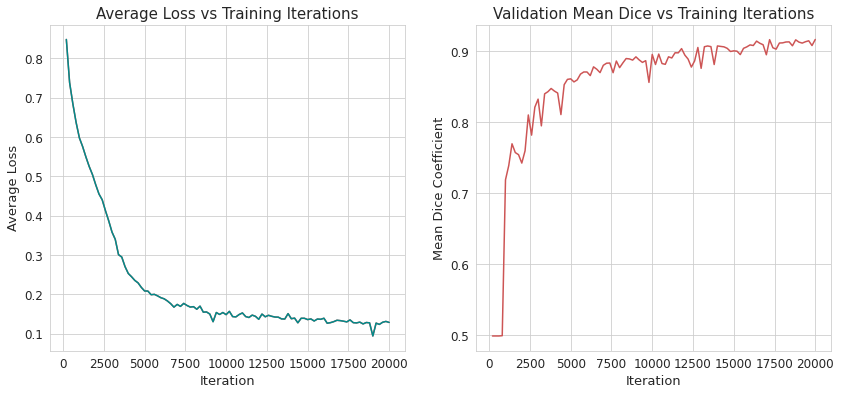

In [15]:
import seaborn as sns
# Figure style
sns.set_style('whitegrid')
# Colour array
colors=[(205/255,85/255,85/255), (0,139/255,139/255)]
# Set colour palette
sns.set_palette(sns.color_palette(colors))

# Plot loss
plt.figure("train", (14, 6))
plt.subplot(1, 2, 1)
plt.title("Average Loss vs Training Iterations",fontsize=15)
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration",fontsize=13)
plt.ylabel("Average Loss",fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(x, y)

# Plot Dice coeff
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Validation Mean Dice vs Training Iterations",fontsize=15)
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration",fontsize=13)
plt.ylabel("Mean Dice Coefficient",fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(x, y)

plt.savefig('new-fetal-files-for-manisha-072022/loss_dice_plots_20000_iterations_v2.eps',bbox_inches='tight')

plt.show()

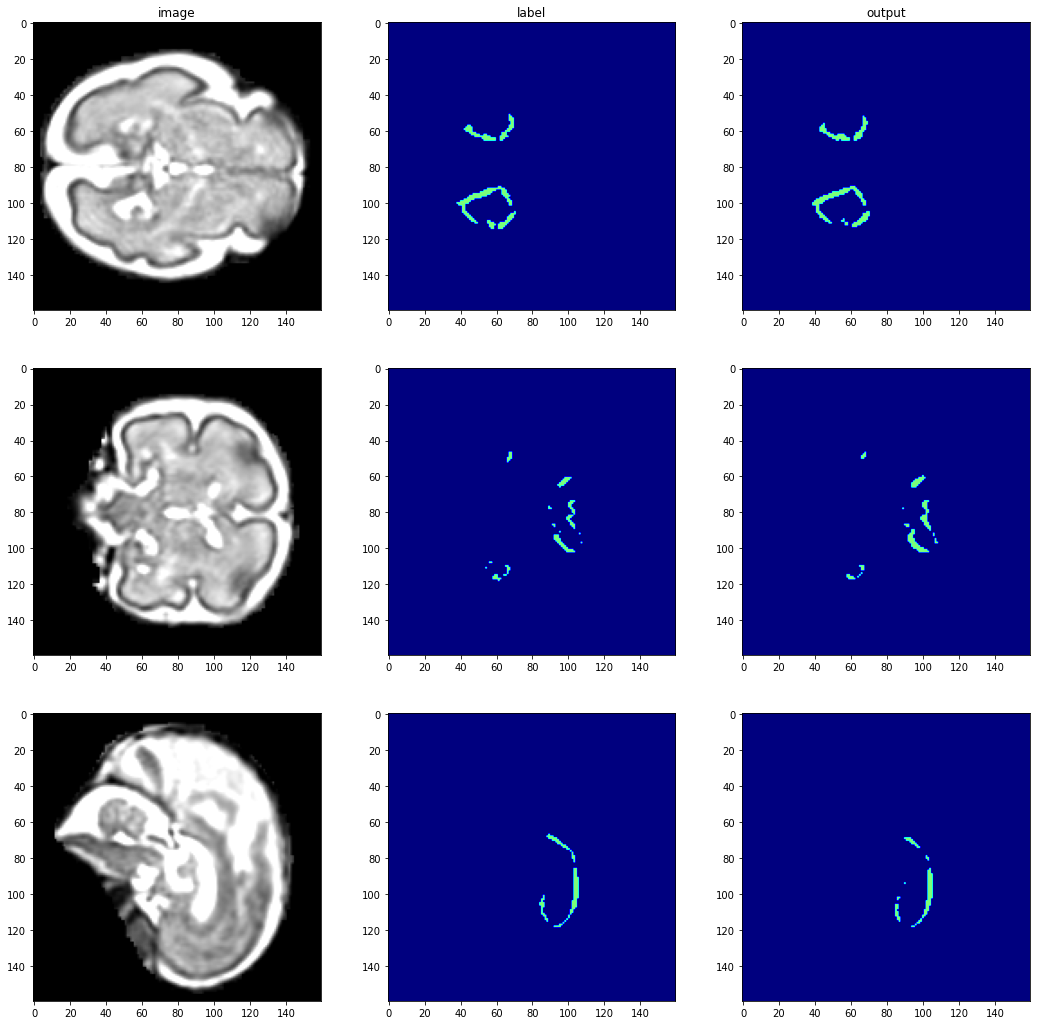

In [12]:
# try running for one of the validation cases and display the results

case_num = 6
class_n = class_num
qq=round(img_dim/2)
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_fetal4.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    cur_case = val_ds[case_num]
    img = cur_case["image"]
    label = cur_case["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
    )
    plt.figure("check", (18, 18))
    plt.subplot(3, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.subplot(3, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, qq], vmin=0, vmax=class_n, cmap="jet")
    plt.subplot(3, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, qq], vmin=0, vmax=class_n, cmap="jet")

    plt.subplot(3, 3, 4)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.subplot(3, 3, 5)
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, qq, :], vmin=0, vmax=class_n, cmap="jet")
    plt.subplot(3, 3, 6)
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, qq, :], vmin=0, vmax=class_n, cmap="jet")


    plt.subplot(3, 3, 7)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.subplot(3, 3, 8)
    plt.imshow(val_labels.cpu().numpy()[0, 0, qq, :, :], vmin=0, vmax=class_n, cmap="jet")
    plt.subplot(3, 3, 9)
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, qq, :, :], vmin=0, vmax=class_n, cmap="jet")

    plt.show()

In [13]:
# save cnn segmentation results for all validation images

val_dir = root_dir + "/new-fetal-files-for-manisha-072022/results/validation_results3"

model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_fetal4.pth"))) # Filename
model.eval()

for x in range(len(val_files)):

  case_num = x
  img_name = val_files[case_num]["image"]
  label_name = val_files[case_num]["label"]
  case_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
  case_name = case_name.rsplit('_',1)[0]
  out_name = val_dir + "/cnn-lab-" + case_name + '.nii.gz'
  print(case_num, out_name)

  img_tmp_info = nib.load(img_name)

  with torch.no_grad():
      img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
      img = val_ds[case_num]["image"]
      label = val_ds[case_num]["label"]
      val_inputs = torch.unsqueeze(img, 1).cuda()
      val_labels = torch.unsqueeze(label, 1).cuda()
      val_outputs = sliding_window_inference(
          val_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
      )

      out_label = torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, :]
      out_lab_nii = nib.Nifti1Image(out_label, img_tmp_info.affine, img_tmp_info.header)
      nib.save(out_lab_nii, out_name)


0 /content/drive/My Drive/Colab Notebooks/MSc Fetal Brain Project//new-fetal-files-for-manisha-072022/results/validation_results3/cnn-lab-sub-CC01158XX12_ses-103830.nii.gz
1 /content/drive/My Drive/Colab Notebooks/MSc Fetal Brain Project//new-fetal-files-for-manisha-072022/results/validation_results3/cnn-lab-sub-CC00991XX19_ses-35230.nii.gz
2 /content/drive/My Drive/Colab Notebooks/MSc Fetal Brain Project//new-fetal-files-for-manisha-072022/results/validation_results3/cnn-lab-sub-CC01165XX11_ses-105931.nii.gz
3 /content/drive/My Drive/Colab Notebooks/MSc Fetal Brain Project//new-fetal-files-for-manisha-072022/results/validation_results3/cnn-lab-sub-CC00999XX27_ses-38031.nii.gz
4 /content/drive/My Drive/Colab Notebooks/MSc Fetal Brain Project//new-fetal-files-for-manisha-072022/results/validation_results3/cnn-lab-sub-CC01114XX09_ses-82430.nii.gz
5 /content/drive/My Drive/Colab Notebooks/MSc Fetal Brain Project//new-fetal-files-for-manisha-072022/results/validation_results3/cnn-lab-sub-C

In [14]:
# save cnn segmentation results for all training images

train_dir = root_dir + "/new-fetal-files-for-manisha-072022/results/training_results3"

model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_fetal4.pth"))) # Filename
model.eval()

for x in range(len(datalist)):

  case_num = x
  img_name = datalist[case_num]["image"]
  label_name = datalist[case_num]["label"]
  case_name = os.path.split(train_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
  case_name = case_name.rsplit('_',1)[0]
  out_name = train_dir + "/cnn-lab-" + case_name + '.nii.gz'
  print(case_num, out_name)

  img_tmp_info = nib.load(img_name)

  with torch.no_grad():
      img_name = os.path.split(train_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
      img = train_ds[case_num]["image"]
      label = train_ds[case_num]["label"]
      train_inputs = torch.unsqueeze(img, 1).cuda()
      train_labels = torch.unsqueeze(label, 1).cuda()
      train_outputs = sliding_window_inference(
          train_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
      )

      out_label = torch.argmax(train_outputs, dim=1).detach().cpu()[0, :, :, :]
      out_lab_nii = nib.Nifti1Image(out_label, img_tmp_info.affine, img_tmp_info.header)
      nib.save(out_lab_nii, out_name)


0 /content/drive/My Drive/Colab Notebooks/MSc Fetal Brain Project//new-fetal-files-for-manisha-072022/results/training_results3/cnn-lab-sub-CC01144XX15_ses-98730.nii.gz
1 /content/drive/My Drive/Colab Notebooks/MSc Fetal Brain Project//new-fetal-files-for-manisha-072022/results/training_results3/cnn-lab-sub-CC00996XX24_ses-38032.nii.gz
2 /content/drive/My Drive/Colab Notebooks/MSc Fetal Brain Project//new-fetal-files-for-manisha-072022/results/training_results3/cnn-lab-sub-CC01031XX09_ses-54930.nii.gz
3 /content/drive/My Drive/Colab Notebooks/MSc Fetal Brain Project//new-fetal-files-for-manisha-072022/results/training_results3/cnn-lab-sub-CC01106XX09_ses-86230.nii.gz
4 /content/drive/My Drive/Colab Notebooks/MSc Fetal Brain Project//new-fetal-files-for-manisha-072022/results/training_results3/cnn-lab-sub-CC01024XX10_ses-48731.nii.gz
5 /content/drive/My Drive/Colab Notebooks/MSc Fetal Brain Project//new-fetal-files-for-manisha-072022/results/training_results3/cnn-lab-sub-CC01109XX12_ses

In [15]:
# save cnn segmentation results for all test images

test_dir = root_dir + "/new-fetal-files-for-manisha-072022/results/test_results3"

model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_fetal4.pth"))) # Filename
model.eval()

for x in range(len(test_files)):

  case_num = x
  img_name = test_files[case_num]["image"]
  #label_name = test_files[case_num]["label"]
  case_name = os.path.split(test_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
  case_name = case_name.rsplit('_',1)[0]
  out_name = test_dir + "/cnn-lab-" + case_name + '.nii.gz'
  print(case_num, out_name)

  img_tmp_info = nib.load(img_name)

  with torch.no_grad():
      img_name = os.path.split(test_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
      img = test_ds[case_num]["image"]
      #label = test_ds[case_num]["label"]
      test_inputs = torch.unsqueeze(img, 1).cuda()
      #test_labels = torch.unsqueeze(label, 1).cuda()
      test_outputs = sliding_window_inference(
          test_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
      )

      out_label = torch.argmax(test_outputs, dim=1).detach().cpu()[0, :, :, :]
      out_lab_nii = nib.Nifti1Image(out_label, img_tmp_info.affine, img_tmp_info.header)
      nib.save(out_lab_nii, out_name)


0 /content/drive/My Drive/Colab Notebooks/MSc Fetal Brain Project//new-fetal-files-for-manisha-072022/results/test_results3/cnn-lab-sub-CC00969XX21_ses-25531.nii.gz
1 /content/drive/My Drive/Colab Notebooks/MSc Fetal Brain Project//new-fetal-files-for-manisha-072022/results/test_results3/cnn-lab-sub-CC00980XX16_ses-28430.nii.gz
2 /content/drive/My Drive/Colab Notebooks/MSc Fetal Brain Project//new-fetal-files-for-manisha-072022/results/test_results3/cnn-lab-sub-CC01126XX13_ses-90530.nii.gz
3 /content/drive/My Drive/Colab Notebooks/MSc Fetal Brain Project//new-fetal-files-for-manisha-072022/results/test_results3/cnn-lab-sub-CC00949XX26_ses-21930.nii.gz
4 /content/drive/My Drive/Colab Notebooks/MSc Fetal Brain Project//new-fetal-files-for-manisha-072022/results/test_results3/cnn-lab-sub-CC01089XX18_ses-72630.nii.gz
5 /content/drive/My Drive/Colab Notebooks/MSc Fetal Brain Project//new-fetal-files-for-manisha-072022/results/test_results3/cnn-lab-sub-CC00962XX14_ses-26230.nii.gz
6 /content